In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
measurequery = session.query(measurement.date,measurement.prcp)
measurequery.order_by(measurement.date.desc()).first().date

'2017-08-23'

<Figure size 720x576 with 0 Axes>

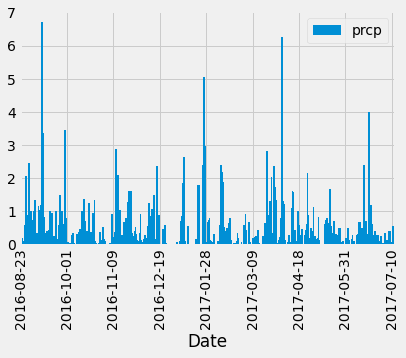

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentpt = measurequery.order_by(measurement.date.desc()).first().date
recentpt
# Calculate the date one year from the last date in data set.
formerdate = dt.date(2017, 8, 23) - dt.timedelta(days=365)
formerdate
# Perform a query to retrieve the data and precipitation scores
dataquery = '''SELECT date, prcp FROM measurement WHERE date > '2016-08-23' '''
# Save the query results as a Pandas DataFrame and set the index to the date column
#data_df = pd.read_sql(dataquery.all(),dataquery.session.bind)
precip_df = pd.read_sql(dataquery, con=conn)
precip_df.set_index("date",inplace=True)
# Sort the dataframe by date
sorted_df = precip_df.sort_index()
sorted_df.dropna(inplace=True)
sorted_df.to_csv("Resources/precip.csv")
# Use Pandas Plotting with Matplotlib to plot the data
#grouped_df=sorted_df.groupby("date").sum()
len(sorted_df)
locticks = [0,250,500,750,1000,1250,1500,1750,2000]
loclabels = ["2016-08-23","2016-10-01","2016-11-09","2016-12-19","2017-01-28",
            "2017-03-09","2017-04-18","2017-05-31","2017-07-10"]
plt.figure(figsize=[10,8])
sorted_df.plot.bar(use_index=False,width=10)
plt.xticks(locticks, loclabels)
plt.xlabel("Date")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stationquery=session.query(station)
stationquery.count()

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station,
              func.count(measurement.station)).filter(measurement.date >= '2016-08-23').group_by(measurement.station).order_by((func.count(measurement.station)).desc()).all()

[('USC00519397', 361),
 ('USC00519281', 352),
 ('USC00516128', 349),
 ('USC00513117', 343),
 ('USC00519523', 337),
 ('USC00514830', 305),
 ('USC00517948', 183)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
filterstation = session.query(measurement).filter_by(station='USC00519397')
hightemp=filterstation.order_by((measurement.tobs).desc()).first().tobs
lowtemp=filterstation.order_by((measurement.tobs).asc()).first().tobs
avgcounts = session.query(func.avg(measurement.tobs))
avgtemp = avgcounts[0][0]
print(f'The highest, lowest, and average temperature for the most active station is {hightemp}, {lowtemp}, and {round(avgtemp,2)} respectively.')
#session.query(measurement.tobs)


The highest, lowest, and average temperature for the most active station is 87.0, 56.0, and 73.1 respectively.


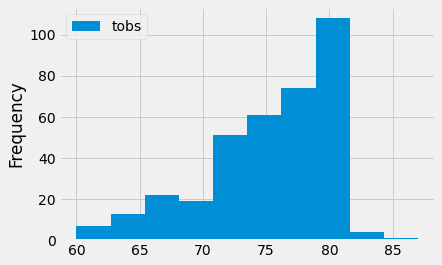

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df=pd.read_sql('''SELECT tobs, date FROM measurement WHERE station = 'USC00519397' AND date > '2016-08-23' ''', conn)
temp_df.plot(kind='hist')

# Close session

In [54]:
# Close Session
session.close()